## Module 3 Final Project 

## Analytical Insights and Hypothesis Testing from Northwind Database

The goal of this project is to conduct a statistical analysis and hypothesis test on the Northwind Traders Database - a dataset created by Microsoft for educational purposes for a fictional company that imports and exports specialty foods globally. 

Our main task is to answer to our stakeholders the following question:

### HYPOTHESIS 1: "Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?"

Besides this question posed by our stakeholders, we are also going to investigate three other hypothesis based on our analysis and understanding of this data.

Our first step in answering the first question is define our null and alternative hypothesis, as well as our alpha value:

**Null Hypothesis** = _there is no difference in product quantity order when there is a discount._

**Alternative Hypothesis** = _discount has a statistically significant impact on product quantity order._

**Alpha = 0.05**  - For this test we will accept an alpha value of 0.05, which means that we will accept a 5% change of rejecting the null hypothesis when it is in fact true.

Now we need to load the data we will need to implement our hypothesis analysis.

In [1]:
# import necessary libraries
import pandas as pd
import sqlite3

# connect to database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

We will look at the database schema below in order to query the information we will need.

<img src='Northwind_ERD_updated.png'>

In [2]:
# query database for the relevant information on orders
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount 
               FROM OrderDetail
               ORDER BY ProductId;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(10)

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10285,1,14.4,45,0.20
1,10294,1,14.4,18,0.00
2,10317,1,14.4,20,0.00
3,10348,1,14.4,15,0.15
4,10354,1,14.4,12,0.00
5,10370,1,14.4,15,0.15
6,10406,1,14.4,10,0.00
7,10413,1,14.4,24,0.00
8,10477,1,14.4,15,0.00
9,10522,1,18.0,40,0.20


In [3]:
# check the basic statistics for this data
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


We can see that we have a total of 2155 product orders and the mean overall quantity on each order regardless of a discount is of 23.81 products, with a median of 20 products and 75% or product orders at 30 products or less. We can also see that the maximum discount level is of 25%. We will investigate further the discount column.

In [4]:
# verify what levels of discount we have
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

We note that we have 5 levels of discount that are the most frequent: 5%, 10%, 15%, 20% and 25%. Because the other levels of discounts do not present enough data, we will choose to drop them and work only with the most common discount levels.

To start, we can separate our data into two different series - no discount and discount, and analyse if the mere presence of a discount has an impact on quantity of products ordered.

In [5]:
# select only the quantity amounts for orders with no discount on a series
no_discount = df.loc[df.Discount == 0, 'Quantity']

no_discount.head()

1    18
2    20
4    12
6    10
7    24
Name: Quantity, dtype: int64

In [6]:
# select rows only on orders that have discount between 5% and 25%
discount_levels = [0.05, 0.10, 0.15, 0.20, 0.25]
discount = df.loc[df.Discount.isin(discount_levels), 'Quantity']

discount.head()

0     45
3     15
5     15
9     40
10     8
Name: Quantity, dtype: int64

In [7]:
# check how many datapoints we have - showing results rounded to one decimal
print(f'''We have {len(no_discount)} product orders with no discount, and {len(discount)} product orders 
with discounts between 5% and 25%.The mean product quantity ordered with no discount is {no_discount.mean():.1f} and 
the mean product quantity for discounted orders is {discount.mean():.1f}.''')

We have 1317 product orders with no discount, and 830 product orders 
with discounts between 5% and 25%.The mean product quantity ordered with no discount is 21.7 and 
the mean product quantity for discounted orders is 27.4.


Let us have a quick look at the distributions of these data with a simple histogram plot.

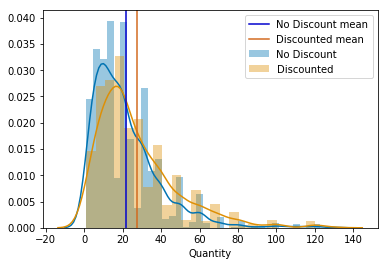

In [8]:
# import vizualization libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_palette('colorblind')

#plot both series on a distribution plot
sns.distplot(no_discount, label='No Discount')
sns.distplot(discount, label='Discounted')
plt.axvline(np.mean(no_discount), color='mediumblue', label='No Discount mean')
plt.axvline(np.mean(discount), color='chocolate', label='Discounted mean')
plt.legend()
plt.show()

We can see from the graph that both distributions are positively skewed, which may indicate some outliers. Also, there seems to be a difference in the mean quantity for discounted products as compared to no discount - this is a good sign but we must perform our statistical tests in order to be able to conclude if such difference is statistically significant. Since what we are initially trying to prove is if there is a difference between quantity in orders with and without a discount, a two-sample t-test is appropriate, using the mean product quantity as our metric.

In [9]:
# import libraries
from scipy import stats 
import math

In [10]:
# let's write down our alpha value for reference
alpha = .05

In [11]:
# to start let's simply find the difference in mean for discounted and not discounted orders
no_discount.mean()
discount.mean()
mean_difference = discount.mean() - no_discount.mean()
round(discount.mean(),1), round(no_discount.mean(),1), round(mean_difference,1)

(27.4, 21.7, 5.6)

We see that we have a difference of 6.11 product units ordered in the mean of products for orders with discount as compared to no discount, but we must further investigate if this difference is statistically significant. Before deciding which type of t-test we will use we must check if our two groups have equal variance. We will perform Bartlett’s test to check it - this test tests the null hypothesis that two sample groups have equal variance.

In [12]:
# perform Bartlett test for variance
stats.bartlett(discount, no_discount)

BartlettResult(statistic=29.48129316230489, pvalue=5.645902482998379e-08)

Our result shows that our discount and no_discount groups **do not** have equal variances. In this case, we must use the 
Welch T-Test in our statistical analysis.

In [13]:
# write a function to run several welch's t-tests

def welch_t(sample1, sample2, alpha=0.05, two_tailed=False):
    ''' takes two samples and alpha value and runs a simple Welch T-Test, returning corresponding p-value.
    Default alpha is 0.05, can pass a different value as parameter
    Default is for one-tailed but can take a two_tailed parameter as True, then returns two-tailed p-value result.'''
    
    # import library
    from scipy import stats 
    
    # run t-test with welch correction
    t, p = stats.ttest_ind(sample1, sample2, equal_var=False)
    
    if two_tailed:
        print(f'Our p-value is of {p}.')
    else:
        print(f'Our p-value is of {p/2}.')

    # compare p-value to our alpha in order to check if we can reject the null hypothesis, 
    if two_tailed:
        if p < alpha:
            print('We can reject the null hypothesis.')
        else:
            print('We failed to reject the null hypothesis.')
    else:
        if p/2 < alpha:
            print('We can reject the null hypothesis.')
        else:
            print('We failed to reject the null hypothesis.')

In [14]:
# test the samples with and without discount to verify if their means are different
welch_t(discount, no_discount)

Our p-value is of 5.0256277704215826e-11.
We can reject the null hypothesis.


Our test and p-value shows us that we can reject our null hypothesis, so we can say at a 95% confidence level that the mean quantity of products ordered is larger when there is a discount offered. We can now further investigate the different discount levels to answer the second part of the question - **at what level of discount we see an effect on quantity ordered?**

In order to do this, we will separate the different discount levels and compare if there is a significant difference among them using a ANOVA test.

In [15]:
# create separate series for each discount level
disc_05 = df.loc[df.Discount == 0.05, 'Quantity']
disc_10 = df.loc[df.Discount == 0.10, 'Quantity']
disc_15 = df.loc[df.Discount == 0.15, 'Quantity']
disc_20 = df.loc[df.Discount == 0.20, 'Quantity']
disc_25 = df.loc[df.Discount == 0.25, 'Quantity']

In [16]:
# check size of each group
print(f'5% discount: {len(disc_05)} \n10% discount: {len(disc_10)} \n15% discount: {len(disc_15)} \n20% discount: {len(disc_20)} \n25% discount: {len(disc_25)}')

5% discount: 185 
10% discount: 173 
15% discount: 157 
20% discount: 161 
25% discount: 154


We can also quickly have a look at the distribution for each group.

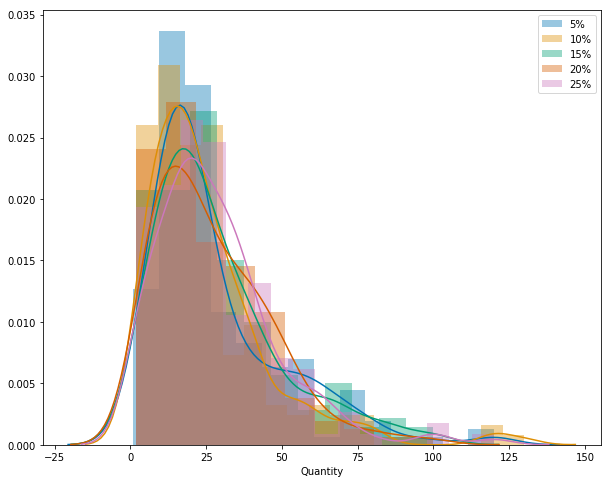

In [17]:
plt.figure(figsize=(10,8))
sns.distplot(disc_05, label='5%')
sns.distplot(disc_10, label='10%')
sns.distplot(disc_15, label='15%')
sns.distplot(disc_20, label='20%')
sns.distplot(disc_25, label='25%')
plt.legend()
plt.show()

They all have a similar shape, with a higher peak at 5% discount, and are approximatelly normally distributed, although positively skewed. I  want to also have a quick look at their bloxplot to see how they might differ in terms of median and outliers.

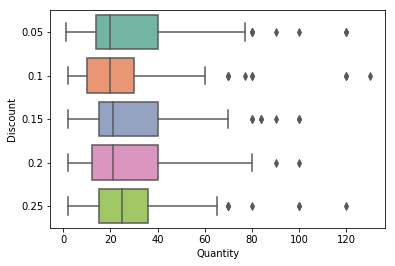

In [18]:
# drop unecessary columns
df_discount = df.drop(columns=['OrderId','ProductId','UnitPrice'])

# select rows with discounts
df_discount = df.loc[df.Discount.isin(discount_levels), ['Quantity', 'Discount']]

df_discount.head()

ax = sns.boxplot(x='Quantity', y='Discount', data=df_discount, orient='h', palette='Set2')

The medians seem close and we don't see much separation among the different data. We still see some outliers approximately above 70 items, for most levels of discount, but since some are present for all and they do not show any signs of being due to erros, we will choose to keep them.

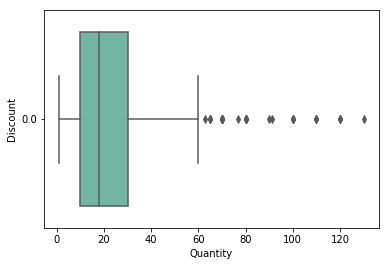

In [19]:
# create dataframe for plotting boxplot
df_no_discount = df.loc[df.Discount == 0, ['Quantity', 'Discount']]
sns.boxplot(x='Quantity', y='Discount', data=df_no_discount, orient='h', palette='Set2')

We can now perform a 1-way ANOVA test now to verify if there is a statistically significant difference amongst the different levels of discount for the mean quantity of products ordered.

In [20]:
# run a one-way ANOVA test using statsmodels
stats.f_oneway(disc_05, disc_10, disc_15, disc_20, disc_25)

F_onewayResult(statistic=0.6741032559876161, pvalue=0.610041445360832)

Our test shows at a 95% confidence level that there is no statistically significant difference amongst the different levels of discounts. To further confirm this and investigate at what discount level we can have an effect, I want to run a welch t-test comparing each discount level to all the others.

In [21]:
# make a list with all the different discount series
list_of_discounts = [disc_05, disc_10, disc_15, disc_20, disc_25]

# run a t-test comparing each level of discount to the others
for i in list_of_discounts:
    for e in list_of_discounts:
        welch_t(i,e)

Our p-value is of 0.5.
We failed to reject the null hypothesis.
Our p-value is of 0.11355233112599261.
We failed to reject the null hypothesis.
Our p-value is of 0.436850968885396.
We failed to reject the null hypothesis.
Our p-value is of 0.32755671499068295.
We failed to reject the null hypothesis.
Our p-value is of 0.46029662412688577.
We failed to reject the null hypothesis.
Our p-value is of 0.11355233112599261.
We failed to reject the null hypothesis.
Our p-value is of 0.5.
We failed to reject the null hypothesis.
Our p-value is of 0.0880825399023959.
We failed to reject the null hypothesis.
Our p-value is of 0.2074729709592535.
We failed to reject the null hypothesis.
Our p-value is of 0.09487792002313435.
We failed to reject the null hypothesis.
Our p-value is of 0.436850968885396.
We failed to reject the null hypothesis.
Our p-value is of 0.0880825399023959.
We failed to reject the null hypothesis.
Our p-value is of 0.5.
We failed to reject the null hypothesis.
Our p-value is 

These results show us that indeed there is no statistically significant difference. So far we learned that discounts do have an effect on quantity ordered, and that there is no statistically significant difference among the different discount levels. We can further investigate how discount affects quantity ordered by getting the effect size of each discount level against a no discount order, since the effect size gives us some measure for the size of the difference between two groups under observation. 

In [22]:
# Import necessary libraries 
import numpy as np

In [23]:
# define function to calculate the Cohen-d effect size for two samples

def cohen_d(group1, group2):
    
    '''Compute Cohen's d.
    Transforms pandas series into numpy arrays for calculations
    returns a floating point number for cohen's d.'''
    
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold 
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return print(f'The Cohen\'s d value is {d}')

In [24]:
# check the observed mean difference in product quantity ordered
print(f'Mean difference in quantity for 5% is of {disc_05.mean() - no_discount.mean():.1f} products.')
print(f'Mean difference in quantity for 10% is of {disc_10.mean() - no_discount.mean():.1f} products.')
print(f'Mean difference in quantity for 15% is of {disc_15.mean() - no_discount.mean():.1f} products.')
print(f'Mean difference in quantity for 20% is of {disc_20.mean() - no_discount.mean():.1f} products.')
print(f'Mean difference in quantity for 25% is of {disc_25.mean() - no_discount.mean():.1f} products.')

Mean difference in quantity for 5% is of 6.3 products.
Mean difference in quantity for 10% is of 3.5 products.
Mean difference in quantity for 15% is of 6.7 products.
Mean difference in quantity for 20% is of 5.3 products.
Mean difference in quantity for 25% is of 6.5 products.


We can see that there is a positive difference in quantity ordered for all levels, although it looks to be smaller for 10% and 20% levels. Let's run the t-test to verify if these differences observed are statistically significant.

In [25]:
# run a welch t-test in a loop to check for statistically significant difference on mean product order quantity
for i in list_of_discounts:
    welch_t(i, no_discount)

Our p-value is of 0.00013616747216423758.
We can reject the null hypothesis.
Our p-value is of 0.01872798305317041.
We can reject the null hypothesis.
Our p-value is of 8.610364721813697e-05.
We can reject the null hypothesis.
Our p-value is of 0.0004055016627021704.
We can reject the null hypothesis.
Our p-value is of 7.96152546106282e-05.
We can reject the null hypothesis.


Our tests show us that all levels of discount have a statistically significant difference in the mean quantity for product ordered. Let's try to grasp the size of this difference using a cohen-d test.

In [26]:
# run a loop to check the Cohen's d value for each level of discount against the no discount sample, from 5% to 25%
for i in list_of_discounts:
    cohen_d(i, no_discount)

The Cohen's d value is 0.3468767736284543
The Cohen's d value is 0.19594203057834086
The Cohen's d value is 0.3724041317472808
The Cohen's d value is 0.3007122542913553
The Cohen's d value is 0.3665925565267441


We seem to have overall a small effect size between all levels of discount and the no discounted prices. Our numbers confirm that 10% discount level has the least effect size on product quantity ordered. Let's verify the power of our analysis as well.

In [27]:
# run a power analysis for all tests
from statsmodels.stats.power import TTestIndPower, TTestPower
power = TTestIndPower()
power_05 = power.power(effect_size=0.3948744653331997, nobs1=len(disc_05), alpha=alpha, ratio=len(no_discount)/len(disc_05), df=(len(disc_05) -1 + len(no_discount)-1), alternative='larger')
power_10 = power.power(effect_size=0.19821666416305028, nobs1=len(disc_10), alpha=alpha, ratio=len(no_discount)/len(disc_10), df=(len(disc_10) -1 + len(no_discount)-1), alternative='larger')
power_15 = power.power(effect_size=0.45301566498890056, nobs1=len(disc_15), alpha=alpha, ratio=len(no_discount)/len(disc_15), df=(len(disc_15) -1 + len(no_discount)-1), alternative='larger')
power_20 = power.power(effect_size=0.3750987110329681, nobs1=len(disc_20), alpha=alpha, ratio=len(no_discount)/len(disc_20), df=(len(disc_20) -1 + len(no_discount)-1), alternative='larger')
power_25 = power.power(effect_size=0.4109384470929913, nobs1=len(disc_25), alpha=alpha, ratio=len(no_discount)/len(disc_25), df=(len(disc_25) -1 + len(no_discount)-1), alternative='larger')

In [28]:
# display results
power_05, power_10, power_15, power_20, power_25

(0.9996403433653782,
 0.7896313760530176,
 0.9999999596290499,
 0.9977853833217226,
 0.9992590585768578)

Our power for these tests is looking very good. Looking at these results, our business recommendation would, innitially, to stick to discount levels of 5%, 15% and 25% discount. 

We can, however, further investigate if the extra quantity compared to the lowered revenue per product makes it worth it for the company, specially since we already see a statistically significant effect on quantity ordered at 5% discount. 

Is applying a larger than 5% discount still worth it in terms of revenue, since the effect of a discount on product quantity is not large? Let's investigate the following hypothesis to give our stakeholders a better understanding of this matter:

### HYPOTHESIS 2 : "Is the mean revenue per product ordered higher at the 5%, 15% and 25% discount levels when compared to product orders with no discounts?

To answer this, we begin by stating our hypothesis:

**null hypothesis:** _The mean revenue per product ordered at 5%, 15% and 25% discount is equal to the mean revenue per product ordered at no discount level_

**alternative hypothesis**: _The mean revenue at either 5%, 15% or 25% is higher than the mean revenue at no discount level_

Let's prepare a dataframe with the information that we need for this task.

In [29]:
# make a list with the discount levels we want to analyse
discounts = [0.00, 0.05, 0.15, 0.25]

# select desided columns and rows with the discounts that we need only
revenue_df = df.loc[df.Discount.isin(discounts), ['Quantity', 'UnitPrice', 'Discount']]

# create new column for revenue, multiplying price per quantity
revenue_df['Revenue'] = df['Quantity']*df['UnitPrice']

In [30]:
# check the overal statistics 
revenue_df.describe()

,Quantity,UnitPrice,Discount,Revenue
count,1813.000000,1813.000000,1813.000000,1813.000000
mean,23.489244,26.540248,0.039327,629.317071
std,18.784050,30.163923,0.077260,1050.407691
min,1.000000,2.000000,0.000000,4.800000
25%,10.000000,12.000000,0.000000,153.300000
50%,20.000000,18.600000,0.000000,360.000000
75%,30.000000,32.800000,0.050000,720.000000
max,130.000000,263.500000,0.250000,15810.000000


In [31]:
# separate data with discounts and no discount
discount_levels = [0.05, 0.15, 0.25]
rev_discount = revenue_df.loc[revenue_df.Discount.isin(discount_levels)]
rev_no_discount = revenue_df.loc[revenue_df.Discount == 0]

# apply discount to revenue for discounted orders
rev_discount['Revenue'] = rev_discount['Revenue'] - (rev_discount['Revenue']*rev_discount['Discount'])

I also want to have a look at the data distribution, using a quick distribution plot.

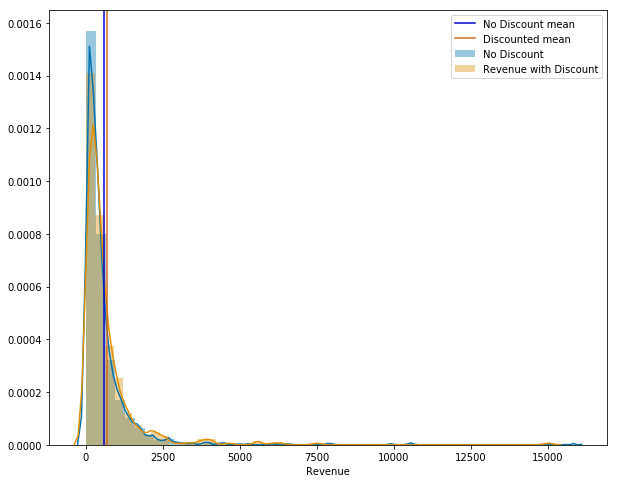

In [32]:
# quick distribution plot
plt.figure(figsize=(10,8))
sns.distplot(rev_no_discount.Revenue, label='No Discount')
sns.distplot(rev_discount.Revenue, label='Revenue with Discount')
plt.axvline(np.mean(rev_no_discount.Revenue), color='mediumblue', label='No Discount mean')
plt.axvline(np.mean(rev_discount.Revenue), color='chocolate', label='Discounted mean')
plt.legend()
plt.show()

Our distributions show positive skewness and high variance. We will likely again we dealing with a Welch correction for our t-tests, and again, the normality of the distribution can be countered by our sample size and the Central Limit Theorem. 

In [33]:
# check difference between mean revenue for no discount and discount
rev_discount.Revenue.mean() - rev_no_discount.Revenue.mean()

103.50579305973986

There is a positive difference between the mean revenue per product order of 103.50 dollars more when there is a discount applied. Again, we must verify if this difference is statistically significant. To do this, we run a welch's t-test.

In [34]:
# use welch_t funcion
welch_t(rev_discount.Revenue,rev_no_discount.Revenue)

Our p-value is of 0.03168790610785079.
We can reject the null hypothesis.


Our test shows that the difference in revenue is statistically significant, so we can reject our null hypothesis that there is no diffference. Let's now further investigate the different levels of discount and their effect on revenue.

In [35]:
# separate samples for different discount levels with their respective revenues
rev_05 = rev_discount.loc[rev_discount.Discount == 0.05, 'Revenue']
rev_15 = rev_discount.loc[rev_discount.Discount == 0.15, 'Revenue']
rev_25 = rev_discount.loc[rev_discount.Discount == 0.25, 'Revenue']

In [36]:
print(f'The difference in mean revenue between 5% discount and no discount is {rev_05.mean() - rev_no_discount.Revenue.mean()}')
print(f'The difference in mean revenue between 15% discount and no discount is {rev_15.mean() - rev_no_discount.Revenue.mean()}')
print(f'The difference in mean revenue between 25% discount and no discount is {rev_25.mean() - rev_no_discount.Revenue.mean()}')

The difference in mean revenue between 5% discount and no discount is 227.9252164686327
The difference in mean revenue between 15% discount and no discount is -12.642371980325834
The difference in mean revenue between 25% discount and no discount is 72.45169293405922


We can see right away that the mean revenue for orders with 15% discount is actually less than for orders with no discount. So far we see a much greater difference in mean revenue at the 5% discount level. We will run a welch t-test to further investigate if these differences that we are observing are statistically significant.

In [37]:
# run welch t for each level of discount against no discount
welch_t(rev_05, rev_no_discount.Revenue)
welch_t(rev_15, rev_no_discount.Revenue)
welch_t(rev_25, rev_no_discount.Revenue)

Our p-value is of 0.018854935319759333.
We can reject the null hypothesis.
Our p-value is of 0.40637345060505425.
We failed to reject the null hypothesis.
Our p-value is of 0.19547470071082323.
We failed to reject the null hypothesis.


Our Welch-t shows that the can only reject the null hypothesis at a 95% confidence level for the 5% discount level when we look at the revenue. We will run a Cohen's d to verify the size of the effect of this discount level on revenue.

In [38]:
# use funcion to get cohen d value
cohen_d(rev_05, rev_no_discount.Revenue)

The Cohen's d value is 0.22085468552388468


What our tests show is that, although in terms of quantity ordered a discount of 15% sounds like the most effective, in terms of revenue once the discounts are applied, 15% is not the ideal level of discount. The best effect we see on revenue comes from a 5% discount, even though such effect is small. Let's also verify the power of our analysis.

In [39]:
# run a power analysis with our results
power.power(effect_size=0.22085468552388468, nobs1=len(rev_05), alpha=alpha, ratio=len(rev_no_discount.Revenue)/len(rev_05), df=(len(rev_05) -1 + len(rev_no_discount.Revenue)-1), alternative='larger')


0.8783448058822063

Our power analysis shows that we can have 87.8% of correctly rejecting the null hypothesis, so we are satisfied with our analysis results. 

We would recommend a 5% discount.

### Hypothesis 3: "Do some regions provide the company better revenue for orders with discount than others?"

We have learned that a discount does increase the number of products ordered, and also that even though we can see an effect on product quantity at any discount level, a positive, statistically signifcant effect on revenue is only observed at a 5% discount level.

I am now curious to understand if the average revenue when there is a discount applied varies depending on the region. To investigage this, I start by stating our hypothesis.

**null hypothesis:** _The mean revenue per order with discount is equal for all regions._

**alternative hypothesis:** _The mean revenue per order with discount is different for different regions._

Let's start by querying our database again for the relevant information we'll need.

In [40]:
# new query of database for the relevant information on orders and regions
cur.execute("""SELECT Quantity*(OrderDetail.UnitPrice - (OrderDetail.UnitPrice*Discount)) as 'Revenue' 
               ,ShipRegion
               ,OrderDetail.OrderID as 'Order_ID'
               FROM OrderDetail 
               LEFT OUTER JOIN `Order`
               ON OrderDetail.OrderID = `Order`.Id
               WHERE Discount!=0
               GROUP BY OrderDetail.OrderID
               ORDER BY SUM(Quantity*(OrderDetail.UnitPrice - (OrderDetail.UnitPrice*Discount))) DESC;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]

# have an overall look at our resulting dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 3 columns):
Revenue       380 non-null float64
ShipRegion    380 non-null object
Order_ID      380 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.0+ KB


In [41]:
# inspect our dataframe
df.head()

,Revenue,ShipRegion,Order_ID
0,1368.0,Western Europe,10865
1,4125.0,North America,11030
2,875.7,South America,10372
3,240.0,North America,10424
4,8432.0,Western Europe,10353


In [42]:
# verifying each data entry is for an unique order
df.Order_ID.nunique()

380

In [43]:
# check how many orders for each region
df.ShipRegion.value_counts()

Western Europe     142
North America       69
South America       67
Northern Europe     32
Southern Europe     30
British Isles       29
Scandinavia          8
Central America      3
Name: ShipRegion, dtype: int64

Neat. We see that some regions have less orders, so we will want to combine them in order to make our sample sizes more similar.

In [44]:
# replace region values to combine them
df.replace('Scandinavia', 'Northern and Southern Europe', inplace=True)
df.replace('British Isles', 'Northern and Southern Europe', inplace=True)
df.replace('Northern Europe', 'Northern and Southern Europe', inplace=True)
df.replace('Southern Europe', 'Northern and Southern Europe', inplace=True)
df.replace('South America', 'South and Central America', inplace=True)
df.replace('Central America', 'South and Central America', inplace=True)

# check new regions and orders totals
df.ShipRegion.value_counts()

Western Europe                  142
Northern and Southern Europe     99
South and Central America        70
North America                    69
Name: ShipRegion, dtype: int64

Good. Now I want to verify the average order revenue, and compare them. 

In [45]:
# calculate the mean revenue per order for each region
w_eu_mean = df.loc[df.ShipRegion == 'Western Europe'].Revenue.mean()
ns_eu_mean = df.loc[df.ShipRegion == 'Northern and Southern Europe'].Revenue.mean()
sc_amer_mean = df.loc[df.ShipRegion == 'South and Central America'].Revenue.mean()
n_amer_mean = df.loc[df.ShipRegion == 'North America'].Revenue.mean()

# print results
print(f'Average revenue per order for Western Europe is {w_eu_mean}.')
print(f'Average revenue per order for Northern and Southern Europe is {ns_eu_mean}.')
print(f'Average revenue per order for South and Central America  is {sc_amer_mean}.')
print(f'Average revenue per order for North America is {n_amer_mean}.')

Average revenue per order for Western Europe is 661.3652746478874.
Average revenue per order for Northern and Southern Europe is 538.7179040404042.
Average revenue per order for South and Central America  is 357.39696428571426.
Average revenue per order for North America is 653.3761231884057.


We can also see that the mean revenue per order for certain regions is higher than others - Western Europe and North America look like the regions generating more revenue per order, although we still need to verify if there is a statistically significant difference. Let's run a ANOVA test to see if what we can find. Let's create our relevant data for the test.

In [46]:
# separate revenue data for each region
western_europe = df.loc[df.ShipRegion == 'Western Europe'].Revenue
northern_southern_europe = df.loc[df.ShipRegion == 'Northern and Southern Europe'].Revenue
south_central_america = df.loc[df.ShipRegion == 'South and Central America'].Revenue
north_america = df.loc[df.ShipRegion == 'North America'].Revenue

In [47]:
# run a one-way ANOVA test using statsmodels
stats.f_oneway(western_europe, northern_southern_europe, south_central_america, north_america)

F_onewayResult(statistic=2.529269356107928, pvalue=0.05699020162543413)

Our p-value shows that there is no statistically significant difference amongst the different regions for mean order revenue when there is a discount applied. So we have failed to reject our hypothesis that a discount will have a different effect on revenue for different regions.

Now I am curious to learn if employees who are using more discounts on orders are actually generating more revenue. We can verify this by looking at our top employees in terms of number of orders with discounts, and comparing them to the mean revenue per order by the other employees. 

### HYPOTHESIS 4: "Are employees who rely more heavily on discounts as sales tool actually bringing in more revenue?"

**null hypothesis:** _The mean revenue per order by the employees who apply more discounts is the same as the mean revenue per order for other employees._

**alternative hypothesis:** _The mean revenue per order by the employees who apply more discounts is higher than the mean revenue per order for other employees._

Let's start by querying again our database for the relevant information.

In [48]:
# new query of database for the relevant information
cur.execute("""SELECT EmployeeId
               ,FirstName || ' ' || LastName
               AS 'Name'
               ,Region
               ,Quantity*(OrderDetail.UnitPrice - (OrderDetail.UnitPrice*Discount))
               AS 'Revenue'
               ,Discount
               FROM [Order]
               LEFT OUTER JOIN Employee
               ON [Order].EmployeeId=Employee.Id
               LEFT OUTER JOIN OrderDetail
               ON [Order].Id=OrderDetail.OrderId;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]

# have an overall look at our resulting dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
EmployeeId    2155 non-null int64
Name          2155 non-null object
Region        2155 non-null object
Revenue       2155 non-null float64
Discount      2155 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 84.3+ KB


In [49]:
# have a quick look at the dataframe
df.head()

,EmployeeId,Name,Region,Revenue,Discount
0,5,Steven Buchanan,British Isles,98.0,0.0
1,5,Steven Buchanan,British Isles,168.0,0.0
2,5,Steven Buchanan,British Isles,174.0,0.0
3,6,Michael Suyama,British Isles,167.4,0.0
4,6,Michael Suyama,British Isles,1696.0,0.0


In [50]:
# check what region we have and which places more orders overall
df.Region.value_counts()

North America    1587
British Isles     568
Name: Region, dtype: int64

We see that most orders come from the North America region. Let's see how many employees we have placing orders, and how many each.

In [51]:
# check number of unique employees and number of each one's orders and save as a series 
total_orders = df.Name.value_counts()
total_orders

Margaret Peacock    420
Nancy Davolio       345
Janet Leverling     321
Laura Callahan      260
Andrew Fuller       241
Robert King         176
Michael Suyama      168
Steven Buchanan     117
Anne Dodsworth      107
Name: Name, dtype: int64

We have 9 employees placing orders. Margaret Peacok has placed the most overall orders, with 420 total, and Anne Dodsworth has the lowest total orders at 107. I'm also curious to see which office each employee belongs to, and their total sales.

In [52]:
# group dataframe by region and employee name, and sum revenue
df2=df.groupby(['Region', 'Name'], as_index=False)['Revenue'].sum()
# sort values in descending order of revenue
df3 = df2.sort_values(['Revenue'], ascending=False)
# add the total orders from data above to dataframe
df3['Total_Orders'] = [420,321,345,241,260,176,107,168,117]
df3['Revenue_per_Order'] = df3['Revenue']/df3['Total_Orders']
df3

,Region,Name,Revenue,Total_Orders,Revenue_per_Order
7,North America,Margaret Peacock,232890.8460,420,554.502014
5,North America,Janet Leverling,202812.8430,321,631.815710
8,North America,Nancy Davolio,192107.6045,345,556.833636
4,North America,Andrew Fuller,166537.7550,241,691.028029
6,North America,Laura Callahan,126862.2775,260,487.931837
2,British Isles,Robert King,124568.2350,176,707.774063
0,British Isles,Anne Dodsworth,77308.0665,107,722.505294
1,British Isles,Michael Suyama,73913.1295,168,439.959104
3,British Isles,Steven Buchanan,68792.2825,117,587.968226


This gives us a good overview of each region's employees, their orders and revenue generated. Let's now check how many orders each employee has placed with discount, and get the rate of discounted orders for each employee so that we learn who relies more heavily on discounts.

In [53]:
# calculate rates of orders with discount for each employee
# create empty dictionary to store data
discount_rates = {}
# use a for loop to get numbers and calculate rate for each employee
for name in total_orders.index:
    discount = df.loc[(df.Name == str(name)) & (df.Discount != 0)]
    total = total_orders[str(name)]
    rate = round((len(discount)/total)*100, 2)
    discount_rates[str(name)] = rate
    print(f'{name} discount rate is {rate}.')

Margaret Peacock discount rate is 40.48.
Nancy Davolio discount rate is 39.13.
Janet Leverling discount rate is 32.4.
Laura Callahan discount rate is 36.15.
Andrew Fuller discount rate is 31.54.
Robert King discount rate is 47.73.
Michael Suyama discount rate is 41.07.
Steven Buchanan discount rate is 50.43.
Anne Dodsworth discount rate is 43.93.


In [54]:
# sort dictionary by higher rates
s = [(k, discount_rates[k]) for k in sorted(discount_rates, key=discount_rates.get, reverse=True)]
for k, v in s:
    print(k, v)

Steven Buchanan 50.43
Robert King 47.73
Anne Dodsworth 43.93
Michael Suyama 41.07
Margaret Peacock 40.48
Nancy Davolio 39.13
Laura Callahan 36.15
Janet Leverling 32.4
Andrew Fuller 31.54


In [55]:
# add column with discounts rates
df3['Discount_Rate']= [40.48,32.4,39.13,31.54,36.15,47.73,43.93,41.07,50.43]
df3

,Region,Name,Revenue,Total_Orders,Revenue_per_Order,Discount_Rate
7,North America,Margaret Peacock,232890.8460,420,554.502014,40.48
5,North America,Janet Leverling,202812.8430,321,631.815710,32.40
8,North America,Nancy Davolio,192107.6045,345,556.833636,39.13
4,North America,Andrew Fuller,166537.7550,241,691.028029,31.54
6,North America,Laura Callahan,126862.2775,260,487.931837,36.15
2,British Isles,Robert King,124568.2350,176,707.774063,47.73
0,British Isles,Anne Dodsworth,77308.0665,107,722.505294,43.93
1,British Isles,Michael Suyama,73913.1295,168,439.959104,41.07
3,British Isles,Steven Buchanan,68792.2825,117,587.968226,50.43


We are gathering very interesting data for our stakeholders. I'm interested in learning the totals and averages for each office for number of orders, revenue and discount rates.

In [56]:
# calculate statistics by region
british_orders = df3[df3['Region']=='British Isles']['Total_Orders'].sum()
british_revenue = round(df3[df3['Region']=='British Isles']['Revenue'].sum(),2)
namerica_orders = df3[df3['Region']=='North America']['Total_Orders'].sum()
namerica_revenue = round(df3[df3['Region']=='North America']['Revenue'].sum(),2)
print(f'''British Isles total orders: {british_orders}; British Isles total revenue: {british_revenue}.
North America total orders: {namerica_orders}; North America total revenue: {namerica_revenue}.''')

British Isles total orders: 568; British Isles total revenue: 344581.71.
North America total orders: 1587; North America total revenue: 921211.33.


In [65]:
# calculate mean revenue per order per region
british_revenue_per_order = df3[df3['Region']=='British Isles']['Revenue_per_Order'].mean()
na_revenue_per_order = df3[df3['Region']=='North America']['Revenue_per_Order'].mean()
all_per_order = df3['Revenue_per_Order'].mean()
print(f'''British Isles mean revenue per order: {british_revenue_per_order}.
North America mean revenue per order: {na_revenue_per_order}
The overall mean revenue per order is {all_per_order}.''')

British Isles mean revenue per order: 614.5516718887292.
North America mean revenue per order: 584.4222452764154
The overall mean revenue per order is 597.8131015485548.


In [64]:
# calculate mean discount rate per region
british_mean_discount_rate = df3[df3['Region']=='British Isles']['Discount_Rate'].mean()
na_mean_discount_rate = df3[df3['Region']=='North America']['Discount_Rate'].mean()
all_discount_rate = df3['Discount_Rate'].mean()
print(f'''British Isles mean discount rate: {british_mean_discount_rate}.
North America mean discount rate: {na_mean_discount_rate}
The overal mean discount rate is {round(all_discount_rate,2)}.''')

British Isles mean discount rate: 45.79.
North America mean discount rate: 35.94
The overal mean discount rate is 40.32.


We see that the British Isles office places much less orders and generates much less total revenue. At the same time, they apply more discounts on average than the North America office, and their mean revenue per order is higher than that of North America office.

We can also see that the employees who use discount the most are Steven Buchanan, Robert King, Anne Dodsworth, and Michael Suyama, all from the British Islands office.

We will create two dataframes, one control with all the other employees orders, and the experiment control with the orders from the employee who has the higher rate of orders with discounts.

In [59]:
# separate dataframes for three employees who give more discounts
top_discounters = ['Steven Buchanan','Robert King']
experiment = df.loc[df['Name'].isin(top_discounters)]
len(experiment)

293

In [60]:
# separate dataframes for each set, experiment for these three employees, control for all others
control = df.loc[~df['Name'].isin(top_discounters)]
len(control)

1862

In [61]:
# verify the difference in mean revenue for each group
print(f'Top discounters mean revenue per order is {experiment.Revenue.mean()}.')
print(f'Other employees\' mean revenue per order is {control.Revenue.mean()}.')
print(f'The difference is of {experiment.Revenue.mean() - control.Revenue.mean()}.')

Top discounters mean revenue per order is 659.9335068259385.
Other employees' mean revenue per order is 575.9573157894736.
The difference is of 83.97619103646491.


In [62]:
welch_t(experiment.Revenue, control.Revenue)

Our p-value is of 0.10241106143991666.
We failed to reject the null hypothesis.


Our analysis shows that we have failed to reject our null hypothesis, so we cannot say that the mean revenue per order for the orders placed by the employee who applies more discounts is statistically significantly different from the orders placed by the other employees. 